In [64]:
import os

**Import Packages**

In [22]:
!pip install rasterio  # Install the rasterio package for reading and writing geospatial raster datasets.
!pip install pvlib  # Install the pvlib package for photovoltaic system modeling.
!pip install matplotlib  # Install the matplotlib package for creating static, interactive, and animated visualizations.
!pip install pymongo  # Install the pymongo package for interacting with the MongoDB database.
!pip install plotly  # Install the plotly package for creating interactive web-based visualizations.

In [63]:
!git clone https://github.com/Aarthi1508/yk-aws-application.git
os.chdir('yk-aws-application/')

Cloning into 'yk-aws-application'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 116 (delta 39), reused 66 (delta 12), pack-reused 0
Receiving objects: 100% (116/116), 6.43 MiB | 5.21 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [57]:
ls

db.sqlite3  djangoproject1/  Dockerfile  manage.py*  README.md  requirements.txt  webapp/


In [58]:
import plotly.graph_objects as go  # Import the plotly graph objects module for creating interactive plots
import json  # Import the JSON module for working with JSON data
import pymongo  # Import the pymongo module for interacting with MongoDB databases
import rasterio  # Import the rasterio module for reading and writing geospatial raster datasets
import numpy as np  # Import the NumPy module for numerical computing
import os  # Import the os module for interacting with the operating system
import matplotlib.pyplot as plt  # Import the matplotlib.pyplot module for creating static plots and visualizations
import pandas as pd  # Import the pandas module for data manipulation and analysis
import datetime  # Import the datetime module for working with dates and times
import pytz  # Import the pytz module for working with time zones

from webapp.shadowingfunction_wallheight_13 import shadowingfunction_wallheight_13 # Import the shadowing function from the shadowingfunction_wallheight_13 module
from webapp.solarposition import * # Import solarposition calculations from the solarposition module


In [65]:
# import the credentials for the MongoDB setup and mapbox account from the secrets.json file
with open('./webapp/secrets.json') as f:
    secrets = json.load(f)

In [67]:
# MongoDB Credentials

# Connect to MongoDB using the client URL from secrets
mongo_client = secrets['MONGODB_CLIENT_URL']

# Access the specified database
mongo_db = secrets['MONGODB_DATABASE']

# Access the specified collection within the database
mongo_collection = secrets['MONGODB_COLLECTION']

In [68]:
mongo_client

'mongodb+srv://<username>:<password>@cluster0-xxxxx.mongodb.net/'

In [62]:
# Mapbox Credentials

# Access the Mapbox access token from secrets
mapbox_access_token = secrets['MAPBOX_ACCESS_TOKEN']

# Access the Mapbox 3D style from secrets
mapbox_3d_style = secrets['MAPBOX_3D_STYLE']

**1. Reading GeoTiff file and extract the bands**

In [41]:
def read_geotiff(input_file):
    # Open the GeoTIFF file
    with rasterio.open(input_file, 'r') as src:
        # Read metadata
        width = src.width
        height = src.height
        count = src.count  # Number of bands
        crs = src.crs.to_epsg()  # EPSG code of the coordinate reference system
        transform = src.transform  # Affine transformation parameters

        # Read each band
        data_arrays = [src.read(band_index + 1) for band_index in range(count)]
        data_names = [src.descriptions[band_index] for band_index in range(count)]

    return {
        'width': width,
        'height': height,
        'count': count,
        'crs': crs,
        'transform': transform,
        'data_arrays': data_arrays,
        'data_names': data_names
    }

In [42]:
# Path to GeoTIFF file
input_tif_file_path = './webapp/data/sample_400_400_sampled.tif' # Replace with the path to your GeoTIFF file

# Read GeoTIFF file
geotiff_data = read_geotiff(os.path.join(input_tif_file_path))

# Access data from geotiff_data dictionary
width = geotiff_data['width']
height = geotiff_data['height']
count = geotiff_data['count']
crs = geotiff_data['crs']
transform = geotiff_data['transform']
data_arrays = geotiff_data['data_arrays']
data_names = geotiff_data['data_names']

# Print metadata information
print(f"Width: {width}, Height: {height}, Bands: {count}")
print(f"Coordinate Reference System (CRS): EPSG:{crs}")
print(f"Affine Transformation: {transform}")

print()

# Accessing individual bands
for band_index, (data_array, data_name) in enumerate(zip(data_arrays, data_names)):
    print(f"Band {band_index + 1} - ({data_name}):")
    print(data_array.shape)

print()

# Accessing individual data arrays
output_latitude_array = data_arrays[0]
output_longitude_array = data_arrays[1]
output_sm_array = data_arrays[2]
output_dem_array = data_arrays[3]

# Rename DEM array to dsm for clarity
dsm = output_dem_array

# Replace NaN values with zeros in DSM array
dsm = np.nan_to_num(dsm, nan=0)

# Print the shape of the DSM array after replacing NaN values
print("DSM shape")
print(dsm.shape)

Width: 400, Height: 400, Bands: 4
Coordinate Reference System (CRS): EPSG:4326
Affine Transformation: | 0.00, 0.00, 0.00|
| 0.00, 0.00, 10.00|
| 0.00, 0.00, 1.00|

Band 1 - (Latitude):
(400, 400)
Band 2 - (Longitude):
(400, 400)
Band 3 - (Surface Material):
(400, 400)
Band 4 - (Elevation Map):
(400, 400)

DSM shape
(400, 400)


**2. Generate Shadow Matrix - Home Page to showcase the study area in mapbox**

In [43]:
def generate_shadow_matrix():
    # Convert latitude and longitude arrays to lists
    latitude_list = output_latitude_array.tolist()
    longitude_list = output_longitude_array.tolist()

    # Calculate the center coordinates
    center_lat = np.mean(latitude_list)
    center_lon = np.mean(longitude_list)

    # Create a scatter plot with Mapbox
    fig = go.Figure(go.Scattermapbox(
        lat=latitude_list,
        lon=longitude_list,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=9
        ),
    ))

    # Update layout with Mapbox style and center
    fig.update_layout(
        mapbox_style='mapbox://styles/mapbox/streets-v11',
        mapbox=dict(
            # Provide Mapbox access token for using Mapbox services
            accesstoken=mapbox_access_token,
            center=dict(lat=center_lat, lon=center_lon),  # Center the map on calculated center coordinates
            zoom=16  # Set initial zoom level
        )
    )

    # Display the plot
    fig.show()

In [44]:
generate_shadow_matrix()

**3. Shadow Analysis function - to perform the shadow analysis and push the results to MongoDB**

(i) This function takes the default timestamp as input if no timestamp is provided by the user.

(ii) Otherwise, it takes the input timestamp if it is provided as an argument to the function


In [45]:
# Define the timezone based on the region, here - CDT

cdt_timezone = pytz.timezone('America/Chicago')

# Function for shadow analysis with optional timestamp parameter
def shadow_analysis(timestamp = datetime.datetime.now(cdt_timezone).strftime('%Y-%m-%d %H:%M:%S')):

    print("Starting the shadow analysis ........")

    # Display DSM plot
    f, ax = plt.subplots(dpi=500)
    plt.imshow(dsm, cmap='viridis')
    plt.title('DSM')
    plt.show()

    # Define latitude and longitude
    lon = -95.30052
    lat = 29.73463

    # Define UTC offset
    utc_offset= -6

    try:
        # Parse input timestamp and format it
        input_datetime = datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
        formatted_timestamp = input_datetime.strftime('%Y-%m-%d %H:%M:%S')
        print("\033[1mFormatted timestamp:\033[0m", formatted_timestamp)
        timestamps = [formatted_timestamp]
    except ValueError:
        print("error: Invalid input timestamp format")

    # Create a DataFrame using the timestamps as a column
    df = pd.DataFrame({'TimeStamp': timestamps})

    # Convert timestamp column to datetime
    df_solar = df.copy()
    df_solar["TimeStamp"] = df_solar["TimeStamp"].apply(pd.to_datetime)
    df_solar.set_index("TimeStamp", inplace = True)

    # Create copy for solar data
    df_solar_data = df.copy()

    # Convert timestamp column to datetime and adjust for UTC time
    df_solar_data['TimeStamp'] = pd.DatetimeIndex(df_solar_data['TimeStamp']) - pd.DateOffset(hours=utc_offset)
    df_solar_data["TimeStamp"] = df_solar_data["TimeStamp"].apply(pd.to_datetime)
    df_solar_data.set_index("TimeStamp", inplace = True)
    df_solar_data["TimeStamp"] = df_solar_data.index

    # Get solar position data
    df_solar = get_solarposition(df_solar_data.index, lat, lon)
    df_solar['TimeStamp'] = pd.DatetimeIndex(df_solar.index) + pd.DateOffset(hours=utc_offset)

    # Select relevant columns for solar data
    df_solar = df_solar[['TimeStamp', 'elevation', 'zenith', 'azimuth']]
    df_solar = df_solar.rename(columns={"elevation": "Elevation","azimuth": "Azimuth", "zenith": "Zenith"})

    # Define scale for shadow analysis
    scale = 1

    # Initialize arrays for shadows
    walls = np.zeros((dsm.shape[0], dsm.shape[1]))
    dirwalls = np.zeros((dsm.shape[0], dsm.shape[1]))

    # Define index for the specific timestamp
    i = 0

    # Get solar altitude and azimuth for the specific timestamp
    altitude = df_solar['Elevation'][i]
    azimuth = df_solar['Azimuth'][i]

    # Get hour and minute for the specific timestamp
    hour = df_solar.index[i].hour
    minute = df_solar.index[i].minute

    # Perform shadow analysis
    sh, wallsh, wallsun, facesh, facesun = shadowingfunction_wallheight_13(dsm, azimuth, altitude, scale, walls, dirwalls * np.pi / 180.)

    # Convert shadow data to DataFrame
    shadow_df = pd.DataFrame(sh)
    shadow_df.columns = [str(column) for column in shadow_df.columns]
    dataframe_dict = shadow_df.to_dict(orient="records")

    try:

        # Connect to MongoDB using the client URL from secrets
        client = pymongo.MongoClient(mongo_client)

        # Access the specified database
        db = client[mongo_db]

        # Access the specified collection within the database
        collection = db[mongo_collection]

        # Get item id for the record
        item_id = collection.count_documents({}) + 1

        # Get current timestamp for the record
        cdt_timezone = pytz.timezone('America/Chicago')
        current_datetime = datetime.datetime.now(cdt_timezone)
        pushed_timestamp = current_datetime.strftime("%Y-%m-%d %H:%M:%S.%f")[:-3]  # Include milliseconds

        # Prepare data to insert into MongoDB
        data_to_insert = {
            "item_id": formatted_timestamp,
            "pushed_timestamp": pushed_timestamp, # this parameter can be used to track the latest shadow matrix from mongodb
            "shadow_matrix": str(dataframe_dict).replace("'", '"')
        }

        print()

        # Insert data into MongoDB collection
        result = collection.insert_one(data_to_insert)
        return_msg = 'Data pushed to MongoDB!'
        print("Record pushed into MongoDB ....")
        print(result)
        client.close()
    except Exception as e:
        print("Error pushing data to MongoDB : {} ".format(e))


Starting the shadow analysis ........


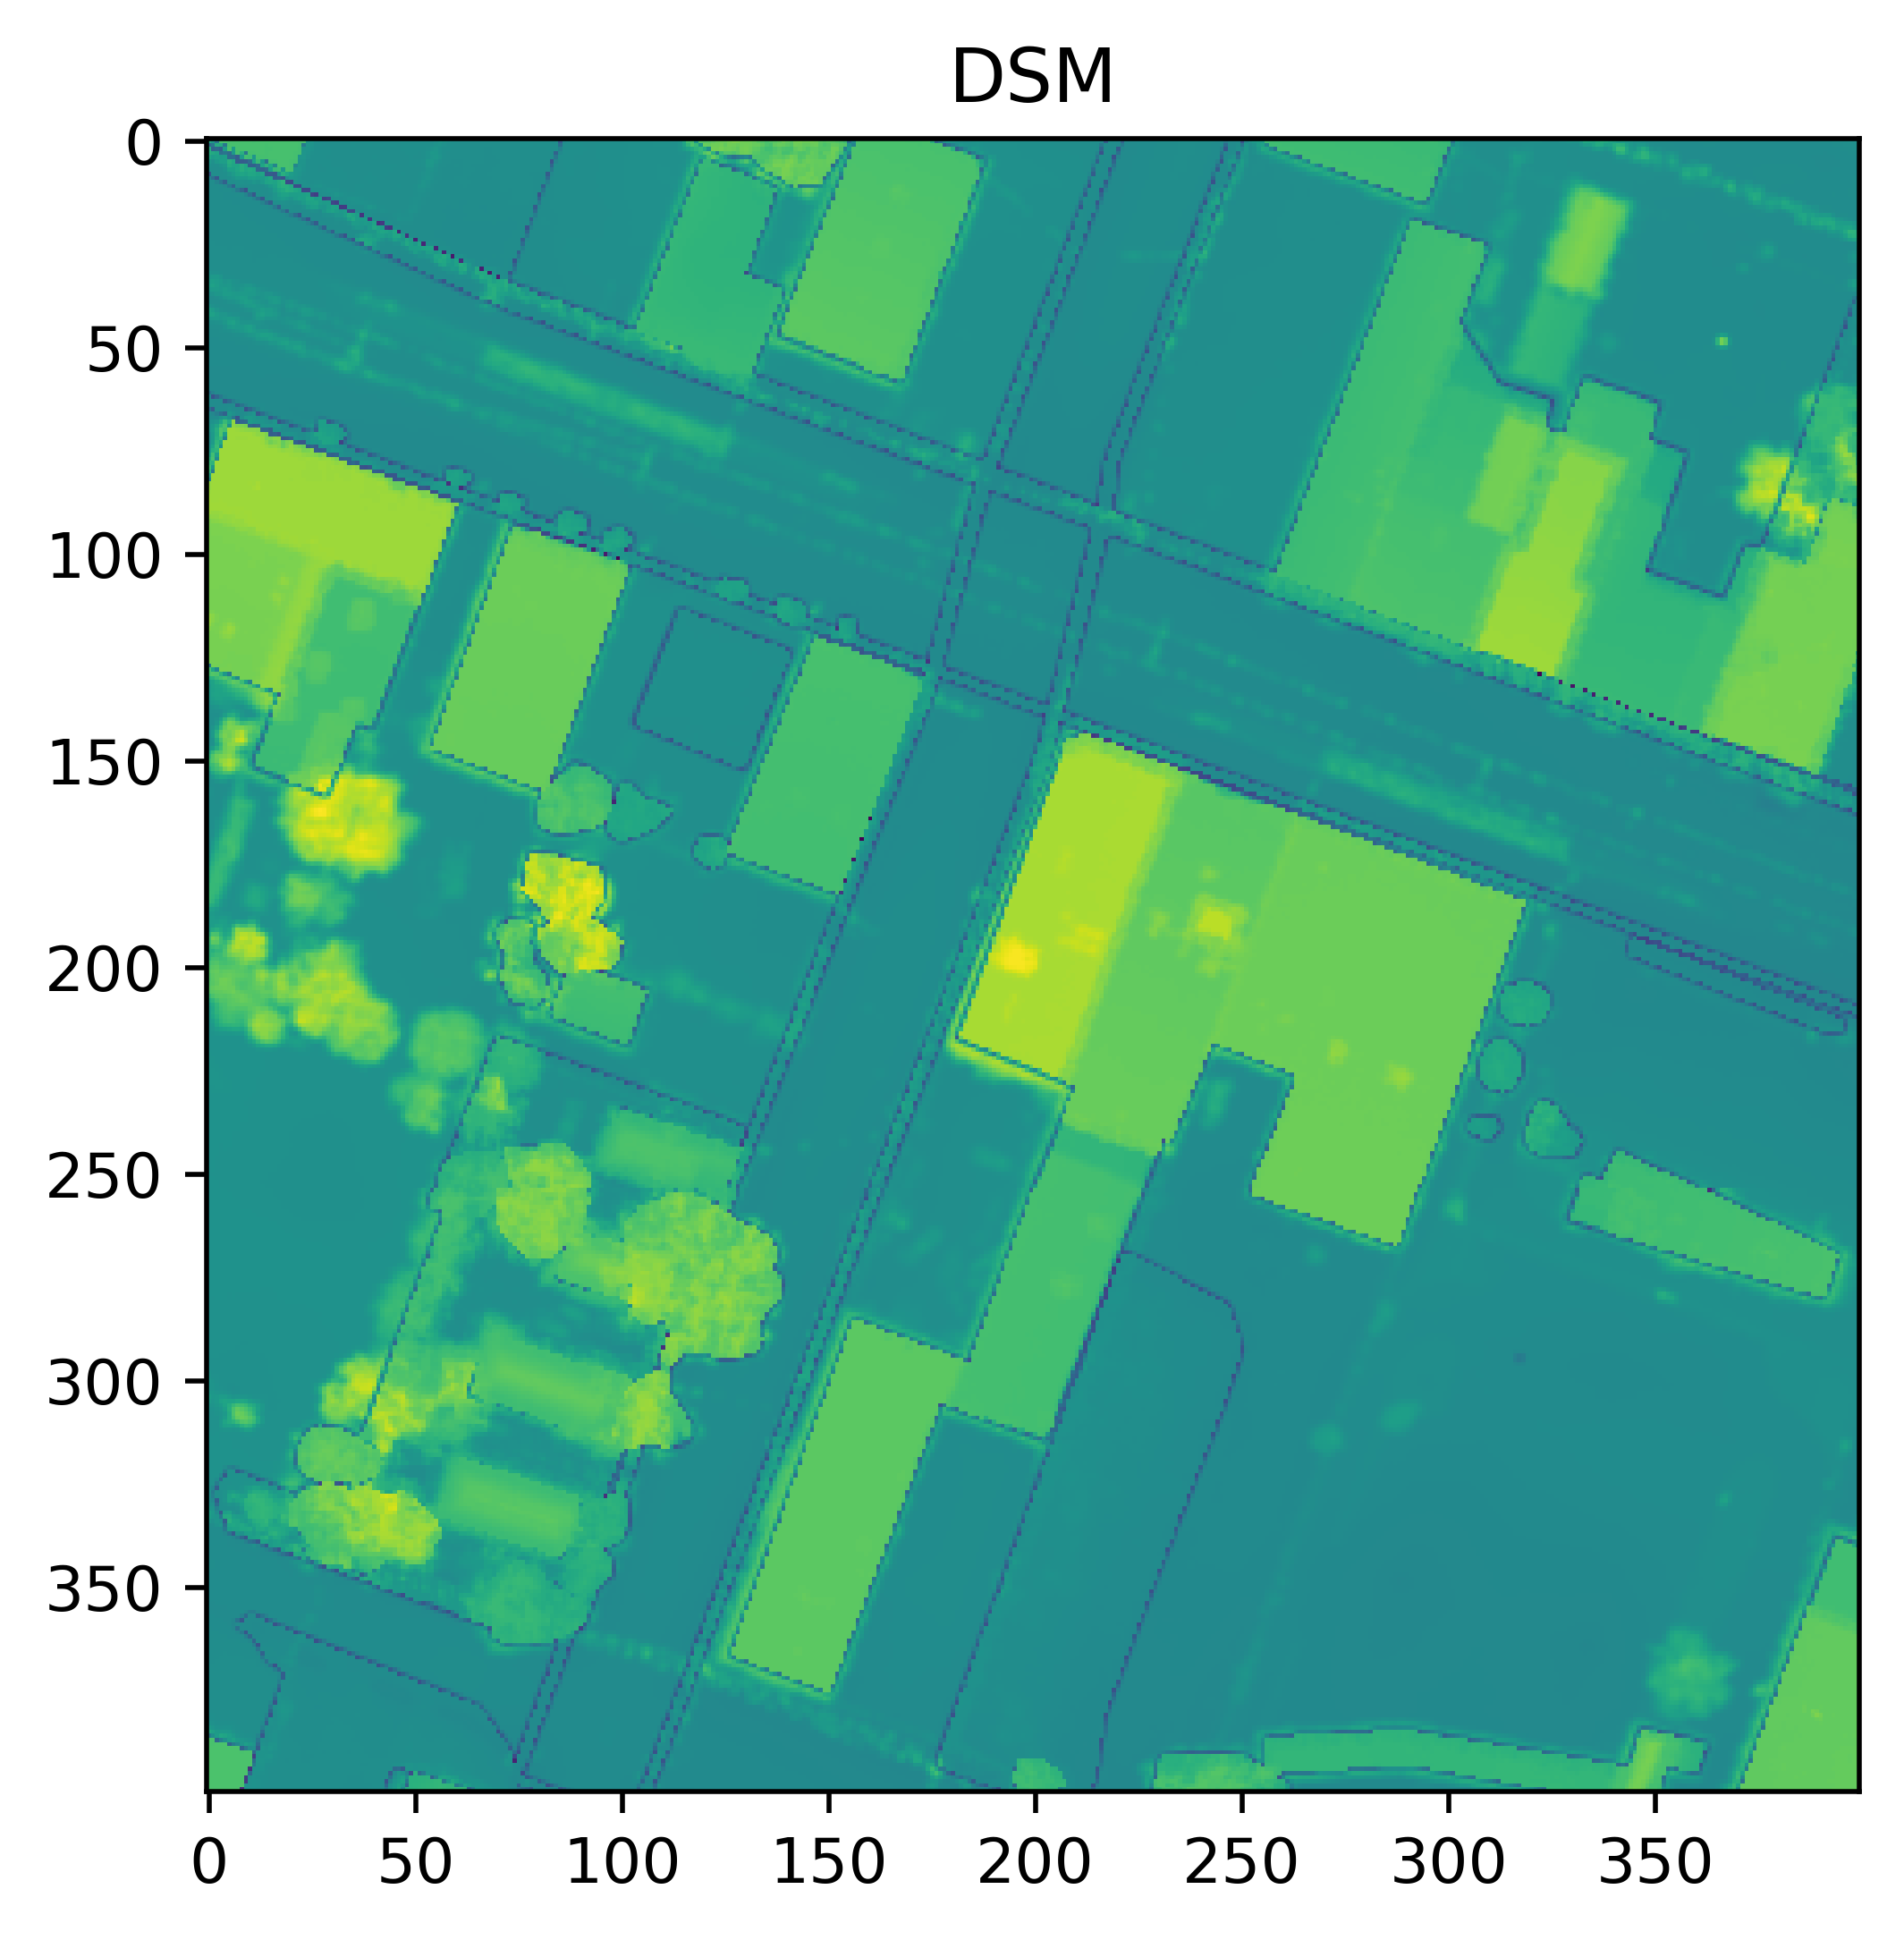

Formatted timestamp: 2024-04-09 15:47:56
Error pushing data to MongoDB : The DNS query name does not exist: _mongodb._tcp.cluster0-xxxxx.mongodb.net. 


In [46]:
# (i) Shadow analysis simluated with default (current timestamp)
shadow_analysis()

Starting the shadow analysis ........


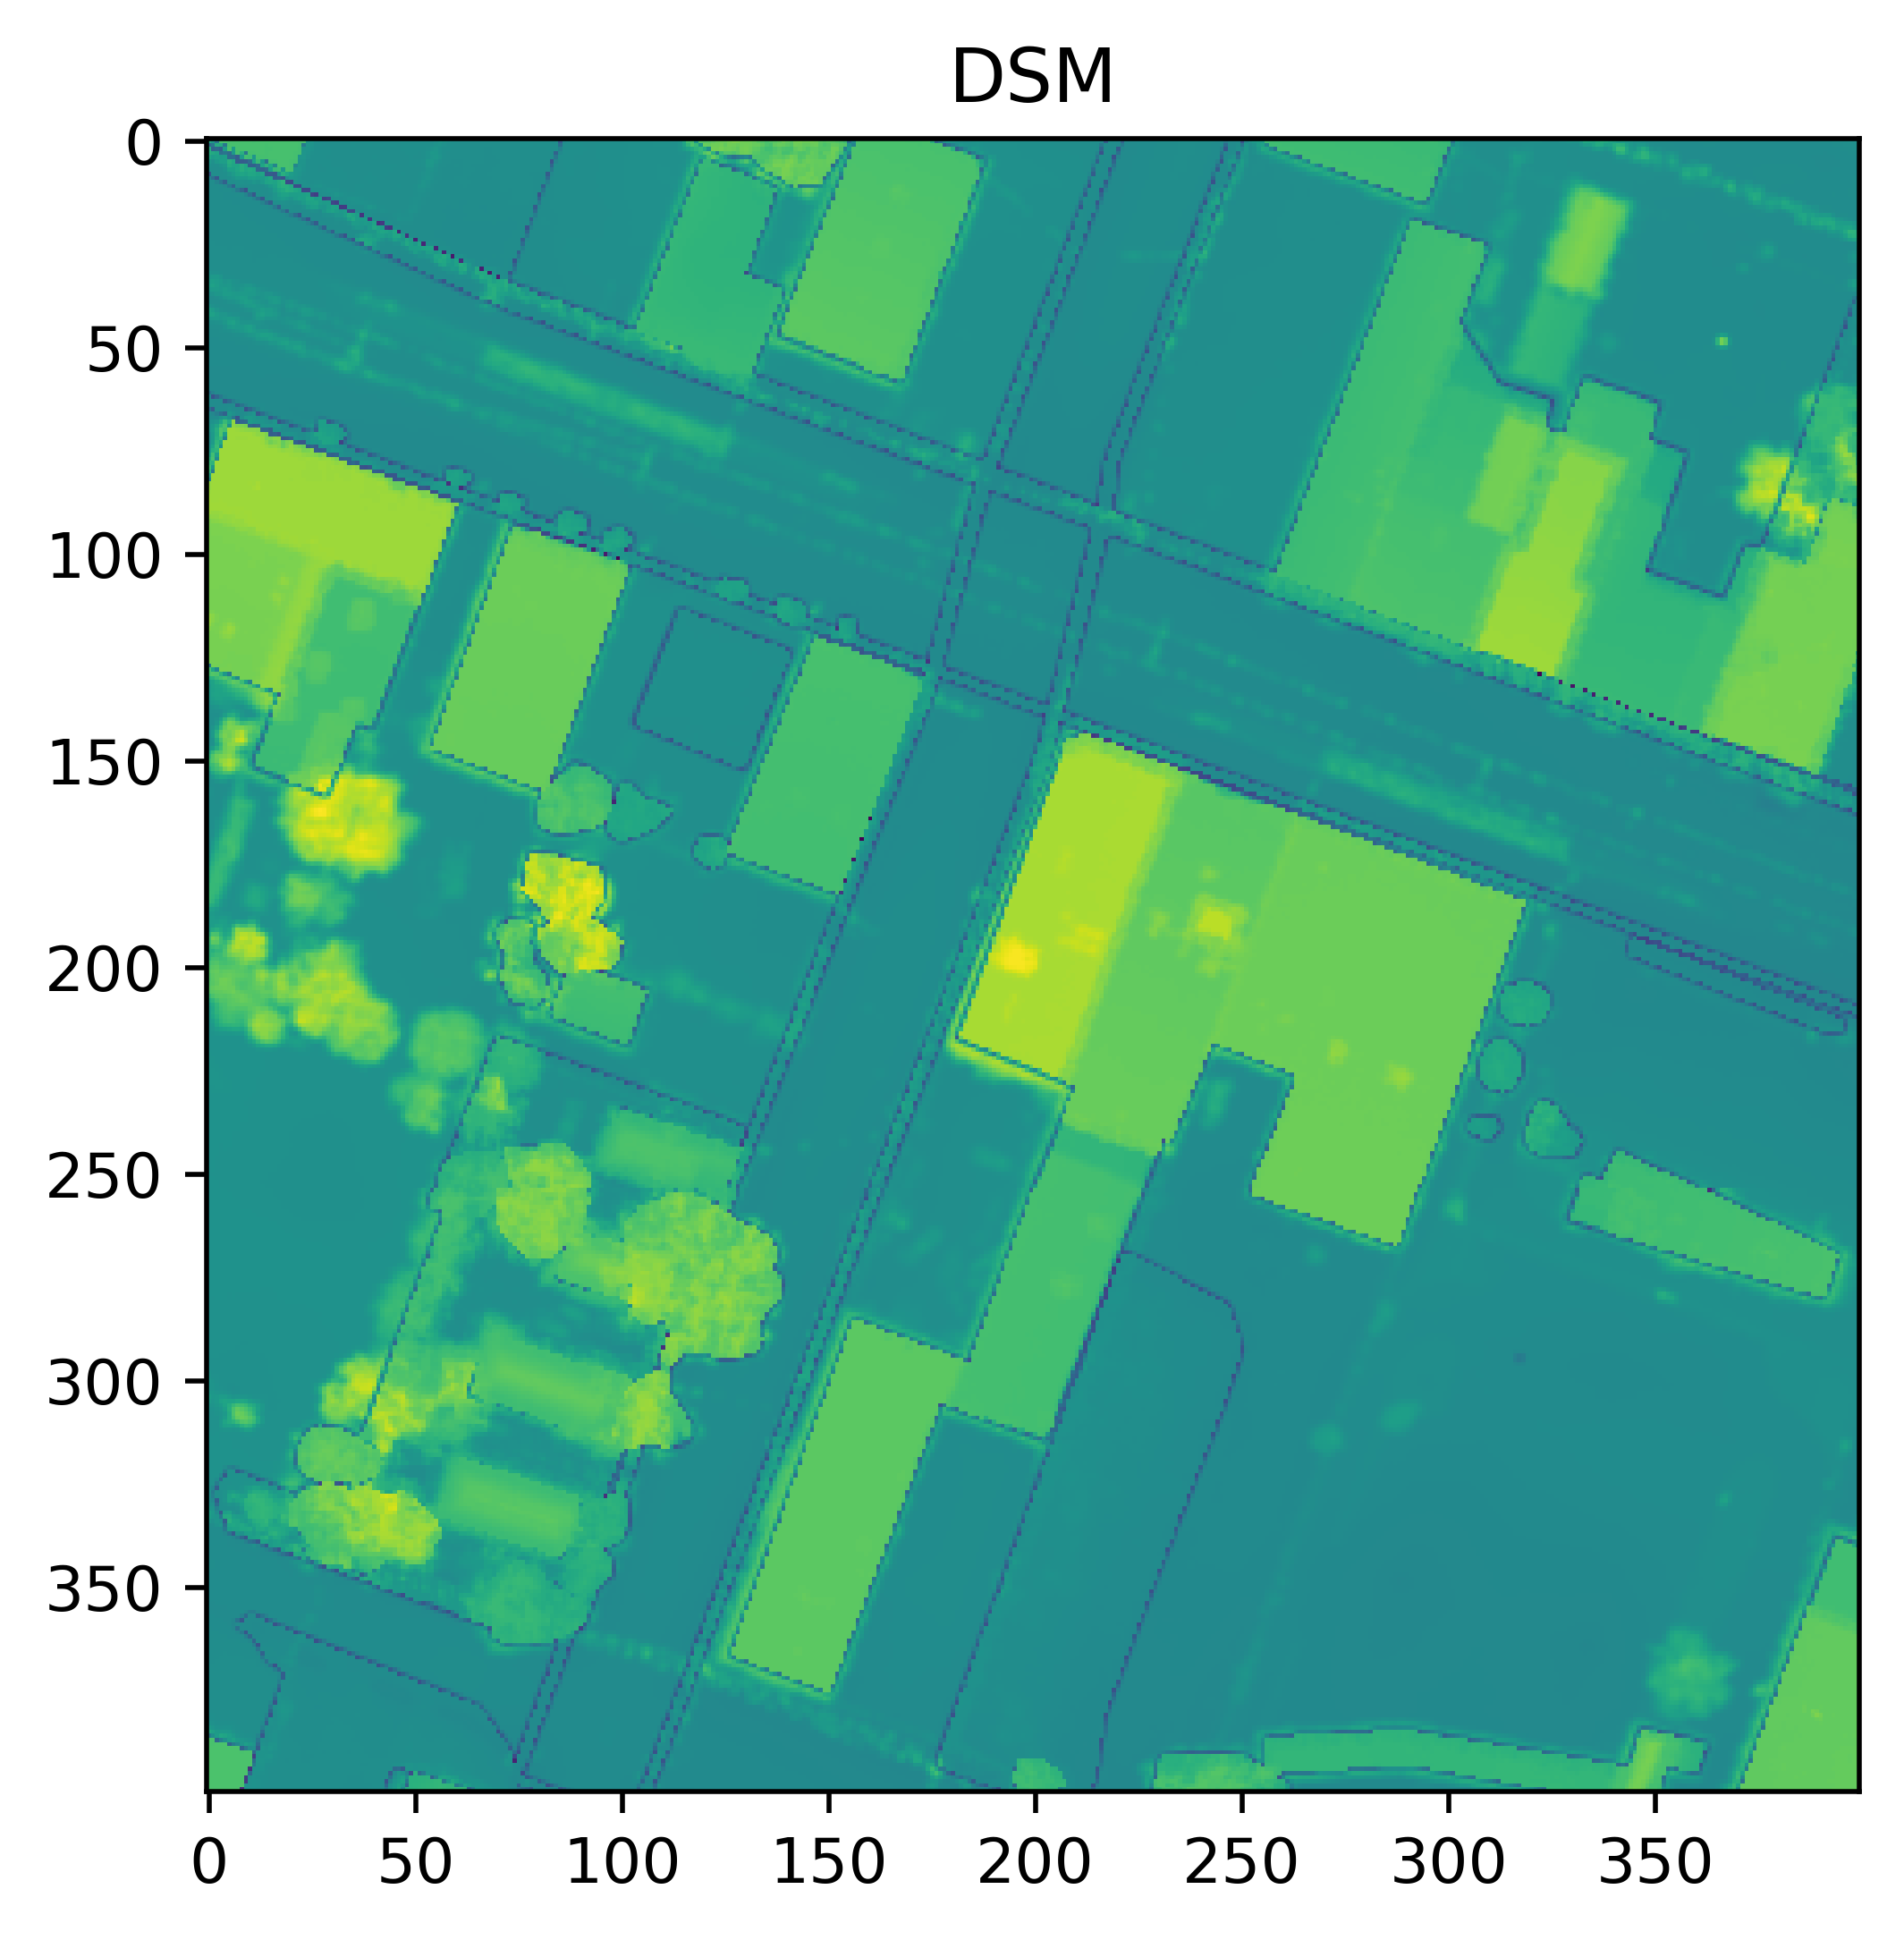

Formatted timestamp: 2024-04-01 15:00:32
Error pushing data to MongoDB : The DNS query name does not exist: _mongodb._tcp.cluster0-xxxxx.mongodb.net. 


In [47]:
# Shadow analysis simluated with custom timestamp

shadow_analysis('2024-04-01 15:00:32') # April 01, 2024 03:00:32 pm

**4. Visualize Shadow Matrix function - to get the latest shadow results (recently pushed) from MongoDB and plot the 2D shadow plot**

In [48]:
def visualize_shadow_matrix():
    # Connect to MongoDB using the client URL from secrets
    client = pymongo.MongoClient(mongo_client)

    # Access the specified database
    db = client[mongo_db]

    # Access the specified collection within the database
    collection = db[mongo_collection]

    # Sort the collection in descending order based on a timestamp field
    # For example, assuming the field name is "timestamp"
    latest_record_cursor = collection.find().sort("pushed_timestamp", -1).limit(1)

    result = {}

    # Iterate over the cursor object
    for latest_record in latest_record_cursor:
        # Print attributes of the latest record
        print("Attributes of the latest record:")
        for key, value in latest_record.items():
            result[key] = value

    # Extract shadow matrix string from the latest record
    shadow_matrix_str = result['shadow_matrix']

    # Convert shadow matrix string to list
    shadow_matrix_lst = json.loads(shadow_matrix_str)

    # Extract year, month, day, hour, minute, and second from the item_id field
    year = str((str(result['item_id'].split()[0])).split('-')[0])
    month = str((str(result['item_id'].split()[0])).split('-')[1])
    day = str((str(result['item_id'].split()[0])).split('-')[2])
    hour = str((str(result['item_id'].split()[1])).split(':')[0])
    minute = str((str(result['item_id'].split()[1])).split(':')[1])
    second = str((str(result['item_id'].split()[1])).split(':')[2])

    # Initialize an empty list to store the values
    values_list = []

    # Iterate over each entry in the list
    for entry in shadow_matrix_lst:
        # Extract the values from the dictionary and append them to the values list
        values_list.append(list(entry.values()))

    # Convert the values list into a NumPy array
    shadow_matrix = np.array(values_list)

    # Print the shape of the array
    print("Shape of the shadow_matrix array:", shadow_matrix.shape)

    # Create a plot to visualize the shadow matrix
    f, ax = plt.subplots(dpi=500)
    plt.imshow(shadow_matrix, cmap='viridis')
    plt.title(str(year) + "-%2s"% str(month).zfill(2) + "-%2s"% str(day).zfill(2) + " %2s" % str(hour).zfill(2) + ":%2s"% str(minute).zfill(2) + ":%2s"% str(second).zfill(2), pad =10, fontsize=10, color="black", weight='bold' )



In [49]:
visualize_shadow_matrix()

ConfigurationError: The DNS query name does not exist: _mongodb._tcp.cluster0-xxxxx.mongodb.net.

**5. Superimpose the latest Shadow Matrix over a general mapbox using plotly**

In [ ]:
def superimpose_shadow_matrix():

    # Connect to MongoDB using the client URL from secrets
    client = pymongo.MongoClient(mongo_client)

    # Access the specified database
    db = client[mongo_db]

    # Access the specified collection within the database
    collection = db[mongo_collection]

    # Sort the collection in descending order based on a timestamp field
    # For example, assuming the field name is "timestamp"
    latest_record_cursor = collection.find().sort("pushed_timestamp", -1).limit(1)

    result = {}

    # Iterate over the cursor object
    for latest_record in latest_record_cursor:
        # Print attributes of the latest record
        print("Attributes of the latest record:")
        for key, value in latest_record.items():
            result[key] = value

    shadow_matrix_str = result['shadow_matrix']
    shadow_matrix_lst = json.loads(shadow_matrix_str)

    # Extract year, month, day, hour, minute, and second from the item_id field

    year = str((str(result['item_id'].split()[0])).split('-')[0])
    month = str((str(result['item_id'].split()[0])).split('-')[1])
    day = str((str(result['item_id'].split()[0])).split('-')[2])

    hour = str((str(result['item_id'].split()[1])).split(':')[0])
    minute = str((str(result['item_id'].split()[1])).split(':')[1])
    second = str((str(result['item_id'].split()[1])).split(':')[2])

    # Initialize an empty list to store the values
    values_list = []

    # Iterate over each entry in the list
    for entry in shadow_matrix_lst:
        # Extract the values from the dictionary and append them to the values list
        values_list.append(list(entry.values()))

    # Convert the values list into a NumPy array
    shadow_matrix = np.array(values_list)

    # Flatten the arrays
    sh_values = shadow_matrix.flatten()
    latitude_values = output_latitude_array.flatten()
    longitude_values = output_longitude_array.flatten()
    sm_values = output_sm_array.flatten()

    # Create a list to store the heatmap coordinates
    heatmap_coordinates = []

    # Iterate over each value in the flattened arrays
    for sh_item, lat, lon, sm_item in zip(sh_values, latitude_values, longitude_values, sm_values):
        heatmap_coordinates.append((lat, lon, sh_item, sm_item))


    elevation_map_trace = go.Scattermapbox(
        mode="markers",
        lat=[coord[0] for coord in heatmap_coordinates],  # Extract latitudes
        lon=[coord[1] for coord in heatmap_coordinates],  # Extract longitudes
        marker=dict(
            size=5,  # Adjust marker size as needed
            color=sh_values,  # Use the sh values for color
            # color=[coord[2] for coord in heatmap_coordinates],  # Use the dem values for color
            colorscale='viridis',  # Use viridis colormap
            cmin=np.min(sh_values),  # Set minimum value for color scale
            cmax=np.max(sh_values),  # Set maximum value for color scale
        )
    )

    # Create the figure with 3D Mapbox layout
    fig = go.Figure(data=elevation_map_trace)

    # Update the layout to use Mapbox in 3D
    fig.update_layout(
        mapbox=dict(
            accesstoken=mapbox_access_token,  # Replace with your Mapbox access token
            style=mapbox_3d_style,  # Specify the Mapbox style URL
            zoom=16,
            center={"lat": np.mean(latitude_values), "lon": np.mean(longitude_values)},
        ),
        scene=dict(
            aspectmode="data",  # Set aspectmode to "data" for equal scaling in 3D
        )
    )

    fig.show()

In [ ]:
superimpose_shadow_matrix()